In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
# TODO
# - add date stamp to all plot file names

import datetime as dt


today = dt.date.today().strftime('%Y-%m-%d')
print(today)


2024-08-24


## IMPORTS

In [3]:
from hdbscan import HDBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import json

from hdbscan.prediction import  all_points_membership_vectors


# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

from matplotlib.colors import LinearSegmentedColormap


from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])

# set the default font for all matplotlib plots
plt.rcParams['font.family'] = 'Aptos'

FONTSIZE = 24

In [4]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

## LOAD DATA

In [5]:
# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-08-04"

In [6]:
# input and output paths
from pathlib import Path

# ftrs = 353
ftrs = 375

p = Path('/Users/david/projects/lc2-1028/')
dfile = p / f"1028-features-{ftrs}-{today}.arrow"

# dfile = Path("/Users/david/projects/lc-project-data/SUBSET-1028-2024-08-23-features.arrow")


# dfile = f"/Users/david/projects/lc-project-data/RECAP-TEST-2024-08-23-features.arrow"


sample_label_file = p / "1028-sample-labels.arrow"


figdir    = p / str(ftrs)
reportdir = "../lc2-report"
data_dir  = "../lc-1028"

In [7]:
# timestamp for saving figures

import datetime as dt

timestamp = dt.datetime.now().strftime("%Y-%m-%d")

# check to see if there is a subdirectory in figdir for the timestamp
import os

if not os.path.exists(os.path.join(figdir, timestamp)):
    os.makedirs(os.path.join(figdir, timestamp))

# redirect output to figdir/timestamp

figdir = Path(os.path.join(figdir, timestamp))

print(figdir)

/Users/david/projects/lc2-1028/375/2024-08-24


In [8]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset


sample_labels = Dataset.load_from_disk(str(sample_label_file))

# load the dataset from disk
ds_all = Dataset.load_from_disk(str(dfile))
ds     = Dataset.load_from_disk(str(dfile))

In [9]:
sl_df = sample_labels.to_pandas()
sl_df = sl_df.drop(columns = ["__index_level_0__"]) # type: ignore

In [10]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [11]:
try:
    df = df.drop(columns = ["__index_level_0__"])
except KeyError:
    pass
df.shape

(1028, 375)

In [12]:
df.columns

Index(['sex', 'age', 'dag', 'SYMPT-abdominal_pain___1',
       'SYMPT-abdominal_pain___2', 'SYMPT-chest_pain___1',
       'SYMPT-chest_pain___2', 'SYMPT-confusion_altered_mental_s___1',
       'SYMPT-confusion_altered_mental_s___2', 'SYMPT-cough___1',
       ...
       'MED-Gastrointestinal-agents', 'MED-Hormonal-agents-(sex-hormones)',
       'MED-Hormonal-agents-(thyroid)', 'MED-Hormone-suppressant-(thyroid)',
       'MED-Metabolic-bone-disease-agents', 'MED-Ophthalmic-agents',
       'MED-Respiratory-tract-agents', 'MED-Skeletal-muscle-relaxants',
       'Sample_Label_ID', 'LC_STATUS'],
      dtype='object', length=375)

In [13]:
# find pregnant in df.columns
pregnant_cols = [col for col in df.columns if "pregnant" in col]
pregnant_cols

['CD-pregnant']

In [14]:
# read the list of columns
with open("/Users/david/projects/lc2-proteomics-data/columns.txt", "r") as f:
    COLS = f.readlines()

# strip newslines from each item in COLS
COLS = [c.strip() for c in COLS]
print(len(COLS))

245


In [15]:
# import good feature names
feature_map_df = pd.read_csv("./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

103 features loaded.
90 colours loaded.


## LC+, LC-, HC

### Select which sets of features to use

In [17]:
# rename the dag column to SITE and map the site names
df = df.rename(columns={"dag": "SITE"})
# df["SITE"] = df["SITE"].map(site_name_dict)
df

sex   age  SITE  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
0     1.0  47.0   1.0                       0.0                       1.0   
1     2.0  37.0   1.0                       0.0                       0.0   
2     2.0  54.0   1.0                       0.0                       0.0   
3     1.0  78.0   1.0                       0.0                       0.0   
4     2.0  33.0   1.0                       0.0                       0.0   
...   ...   ...   ...                       ...                       ...   
1023  2.0  63.0   1.0                       0.0                       0.0   
1024  2.0  69.0   1.0                       0.0                       0.0   
1025  2.0  31.0   1.0                       0.0                       0.0   
1026  2.0  26.0   1.0                       0.0                       0.0   
1027  2.0  45.0   1.0                       0.0                       0.0   

      SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
0                      0.0                   0.0   
1                      0.0                   0.0   
2                      0.0                   0.0   
3                      0.0                   0.0   
4                      1.0                   0.0   
...                    ...                   ...   
1023                   0.0                   0.0   
1024                   0.0                   0.0   
1025                   0.0                   0.0   
1026                   0.0                   0.0   
1027                   0.0                   0.0   

      SYMPT-confusion_altered_mental_s___1  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      0.0   
4                                      1.0   
...                                    ...   
1023                                   0.0   
1024                                   0.0   
1025                                   0.0   
1026                                   0.0   
1027                                   0.0   

      SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
0                                      1.0              1.0  ...   
1                                      0.0              1.0  ...   
2                                      1.0              1.0  ...   
3                                      0.0              0.0  ...   
4                                      1.0              1.0  ...   
...                                    ...              ...  ...   
1023                                   0.0              0.0  ...   
1024                                   0.0              0.0  ...   
1025                                   0.0              0.0  ...   
1026                                   0.0              0.0  ...   
1027                                   0.0              0.0  ...   

      MED-Gastrointestinal-agents  MED-Hormonal-agents-(sex-hormones)  \
0                               1                                   0   
1                               0                                   0   
2                               0                                   0   
3                               1                                   0   
4                               0                                   0   
...                           ...                                 ...   
1023                            0                                   0   
1024                            0                                   0   
1025                            0                                   0   
1026                            0                                   0   
1027                            0                                   0   

      MED-Hormonal-agents-(thyroid)  MED-Hormone-suppressant-(thyroid)  \
0                                 0                                  0   
1                                 0                          

In [18]:
LC_pos = df.query('LC_STATUS == 1').copy() # type: ignore
# LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
# LC_neg = df.query('LC_STATUS == 0').copy() # type: ignore 
# HC     = df.query('LC_STATUS == 2').copy()     # type: ignore

In [19]:
LC_pos.shape

(494, 375)

In [20]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except KeyError:
    pass
LC_pos

sex   age  SITE  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
0    1.0  47.0   1.0                       0.0                       1.0   
1    2.0  37.0   1.0                       0.0                       0.0   
2    2.0  54.0   1.0                       0.0                       0.0   
3    1.0  78.0   1.0                       0.0                       0.0   
4    2.0  33.0   1.0                       0.0                       0.0   
..   ...   ...   ...                       ...                       ...   
978  1.0  25.0   5.0                       0.0                       0.0   
979  1.0  51.0   5.0                       0.0                       0.0   
980  1.0  50.0   5.0                       0.0                       0.0   
981  1.0  71.0   4.0                       0.0                       0.0   
982  2.0  68.0   4.0                       0.0                       0.0   

     SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
0                     0.0                   0.0   
1                     0.0                   0.0   
2                     0.0                   0.0   
3                     0.0                   0.0   
4                     1.0                   0.0   
..                    ...                   ...   
978                   1.0                   0.0   
979                   0.0                   0.0   
980                   1.0                   1.0   
981                   0.0                   0.0   
982                   0.0                   0.0   

     SYMPT-confusion_altered_mental_s___1  \
0                                     0.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   
..                                    ...   
978                                   0.0   
979                                   0.0   
980                                   0.0   
981                                   0.0   
982                                   0.0   

     SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
0                                     1.0              1.0  ...   
1                                     0.0              1.0  ...   
2                                     1.0              1.0  ...   
3                                     0.0              0.0  ...   
4                                     1.0              1.0  ...   
..                                    ...              ...  ...   
978                                   0.0              1.0  ...   
979                                   0.0              0.0  ...   
980                                   0.0              1.0  ...   
981                                   0.0              0.0  ...   
982                                   0.0              0.0  ...   

     MED-Dermatological-agents  MED-Gastrointestinal-agents  \
0                            0                            1   
1                            0                            0   
2                            0                            0   
3                            0                            1   
4                            0                            0   
..                         ...                          ...   
978                          0                            0   
979                          0                            0   
980                          0                            0   
981                          0                            0   
982                          0                            0   

     MED-Hormonal-agents-(sex-hormones)  MED-Hormonal-agents-(thyroid)  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              1   
3                                     0                              0   
4     

In [21]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 20
VAX 1
HHX 49
IMG 0
LAB 0
SUBS 0


# CLUSTERING

In [22]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [23]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


# drop dag
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'dag').columns)

# drop columns that start with CD and end with ___1
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD.*___1').columns)


# cdrop cols of type object
LC_pos_ = LC_pos_.select_dtypes(exclude = ['object'])



print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(494, 175)
(494, 175)


In [24]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

new_symptoms = []

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms + lc_symptoms
# new_and_worse = lc_symptoms

In [25]:
# sort new_and_worse
new_and_worse = sorted(new_and_worse)

In [26]:
# read the list of columns
with open("/Users/david/projects/lc2-proteomics-data/columns.txt", "r") as f:
    COLS = f.readlines()

# strip newslines from each item in COLS
COLS = [c.strip() for c in COLS]
print(len(COLS))

245


In [27]:
print(len(LC_pos_.columns))

175


In [28]:
# what's the difference bertween ftrs and COLS?
# ftrs are the columns in the dataframe
# COLS are the columns in the proteomics data

# get the intersection of ftrs and COLS
# this is the list of columns that are in the dataframe and the proteomics data

set(LC_pos_.columns) - set(COLS)

{'CD-bmi',
 'CD-cardiovascular_complicatio___2',
 'CD-complications_of_the_endoc___2',
 'CD-gastrointestinal_complicat___2',
 'CD-height_m',
 'CD-neurologic_complications___2',
 'CD-psychiatric_complications___2',
 'CD-renal_complications___2',
 'CD-respiratory_complications___2',
 'CD-weight_kgs',
 'SITE'}

In [29]:
set(COLS) - set(LC_pos_.columns)

{'CD-acute_kidney_injury___1',
 'CD-acute_respiratory_distress___1',
 'CD-adjunctive___1',
 'CD-anemia___1',
 'CD-anxiety___1',
 'CD-asthma___1',
 'CD-bacterial_viral_or_cryptog___1',
 'CD-bacteriemia___1',
 'CD-brain_fog___1',
 'CD-bronchiolitis___1',
 'CD-cardiac_arrest___1',
 'CD-cardiovascular-other-1',
 'CD-cardiovascular-other-2',
 'CD-copd___1',
 'CD-decompensated_heart_failur___1',
 'CD-deep_vein_thrombosis_dvt___1',
 'CD-depression___1',
 'CD-difficulty_with_concentrat___1',
 'CD-disseminated_intravascular___1',
 'CD-encephalitis___1',
 'CD-endocarditis___1',
 'CD-endocrine-other-1',
 'CD-endocrine-other-2',
 'CD-gastrointestinal-other-1',
 'CD-gastrointestinal-other-2',
 'CD-gastrointestinal_haemorrha___1',
 'CD-hyperglycemia___1',
 'CD-hypoglycemia___1',
 'CD-insomnia___1',
 'CD-interstitial_lung_disease___1',
 'CD-left_ventricular_function___1',
 'CD-liver_dysfunction___1',
 'CD-medication_received___1',
 'CD-memory_problems___1',
 'CD-meningitis___1',
 'CD-mood_change___1'

In [30]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except KeyError:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore
# X = scaler.fit_transform(LC_pos_)     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

In [31]:
X.shape

(494, 174)

In [32]:
sites = df["SITE"].apply(lambda x: site_name_dict[x])


# use only the sites with indices in the LC_pos_ dataframe
sites = sites.loc[LC_pos_.index]
sites.shape


(494,)

## Use UMAP to visualize the data and cluster

### Handling missing values

In [33]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 1)

print(X.shape)

(494, 159)


In [34]:
# is SITE in X?
"SITE" in X.columns


False

### EMBED and CLUSTER

In [35]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
                # 'metric': 'hamming',
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
points   = pipe["embed"].embedding_ # type: ignore
clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels


plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = [c+1 for c in clusters]
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# plot_df, cluster_labels = make_plot_df(pipe, 
#                                         sites,
#                                         site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(random_state=42, spread=5.0, verbose=True)
Sat Aug 24 23:06:01 2024 Construct fuzzy simplicial set


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sat Aug 24 23:06:02 2024 Finding Nearest Neighbors
Sat Aug 24 23:06:03 2024 Finished Nearest Neighbor Search
Sat Aug 24 23:06:04 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Aug 24 23:06:05 2024 Finished embedding


In [36]:
plot_df

x          y  Cluster  Cluster Confidence Site
0   -11.340892   9.693447        5            0.000000  LDN
1    -4.905222   0.300044        4            0.000000  LDN
2    -5.012092  16.516722        1            0.000000  LDN
3     8.550085  12.469810        2            0.940697  LDN
4    -4.014303  10.030358        4            1.000000  LDN
..         ...        ...      ...                 ...  ...
978  14.660732  12.907857        2            1.000000  LUS
979   7.358306   9.509048        2            0.000000  LUS
980   5.061853  10.869988        2            0.000000  LUS
981  12.308512  13.964569        2            1.000000  RIO
982  -4.575456   0.569463        4            0.000000  RIO

[494 rows x 5 columns]

In [37]:
# add the sample labels to the plot_df
# plot_df = pd.concat([plot_df, sl_df], axis = 1)

# join sl_df to plot_df
plot_df = plot_df.join(sl_df, how = "inner")



plot_df

x          y  Cluster  Cluster Confidence Site Sample_Label_ID
0   -11.340892   9.693447        5            0.000000  LDN        LDN-0001
1    -4.905222   0.300044        4            0.000000  LDN        LDN-0002
2    -5.012092  16.516722        1            0.000000  LDN        LDN-0003
3     8.550085  12.469810        2            0.940697  LDN        LDN-0004
4    -4.014303  10.030358        4            1.000000  LDN        LDN-0005
..         ...        ...      ...                 ...  ...             ...
978  14.660732  12.907857        2            1.000000  LUS        LUS-0353
979   7.358306   9.509048        2            0.000000  LUS        LUS-0174
980   5.061853  10.869988        2            0.000000  LUS        LUS-0319
981  12.308512  13.964569        2            1.000000  RIO        RIO-0074
982  -4.575456   0.569463        4            0.000000  RIO        RIO-0100

[494 rows x 6 columns]

In [38]:
# prepare to export the plot_df

# make a copy that excludes x and y
plot_df2 = plot_df.drop(columns = ["x", "y", "Cluster Confidence"])

# save as an excel fdile

fn = figdir / f"lc-1028-clusters-with-sample-label-id-{timestamp}.xlsx"

plot_df2.to_excel(figdir / fn)

In [39]:
plot_df2

Cluster Site Sample_Label_ID
0          5  LDN        LDN-0001
1          4  LDN        LDN-0002
2          1  LDN        LDN-0003
3          2  LDN        LDN-0004
4          4  LDN        LDN-0005
..       ...  ...             ...
978        2  LUS        LUS-0353
979        2  LUS        LUS-0174
980        2  LUS        LUS-0319
981        2  RIO        RIO-0074
982        4  RIO        RIO-0100

[494 rows x 3 columns]

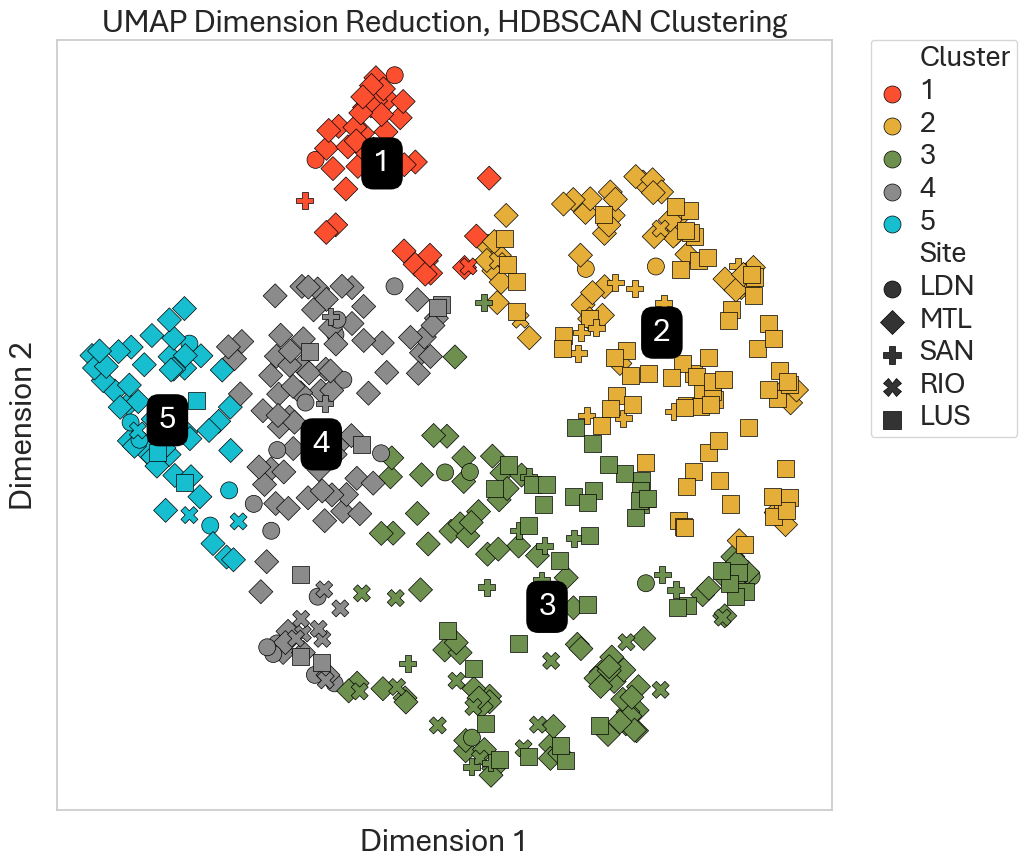

In [40]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = "UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

#### Cluster by Site

In [41]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site.copy()

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster     1     2     3     4     5
Site                                 
LDN       2.0   2.0   5.0  15.0   5.0
MTL      39.0  48.0  82.0  76.0  48.0
SAN       1.0  10.0  13.0   2.0   0.0
RIO       1.0   3.0  14.0   8.0   3.0
LUS       0.0  69.0  38.0   7.0   3.0


In [42]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/basic-cluster-by-site.tex")

In [43]:
c1 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)#.astype(int)
c1 = c1.loc[site_name_dict.values()]
c1

Cluster         1         2         3         4         5
Site                                                     
LDN      0.046512  0.015152  0.032895  0.138889  0.084746
MTL      0.906977  0.363636  0.539474  0.703704  0.813559
SAN      0.023256  0.075758  0.085526  0.018519  0.000000
RIO      0.023256  0.022727  0.092105  0.074074  0.050847
LUS      0.000000  0.522727  0.250000  0.064815  0.050847

#### RFC Model to identify features that differentiate clusters

In [44]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 90
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100


BorutaPy finished running.

Iteration: 	35 / 100
Confirmed: 	27
Tentative: 	0
Rejected: 	132


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=106,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x317E77C40),
         n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x317E77C40, verbose=1)

In [45]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=106, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x317E77C40)

In [46]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 20, feature_map, feature_colour_map)


In [47]:
features20

Feature  Importance  \
0                       LC+ Dyspnea    1.000000   
1                               Sex    0.807174   
2                       LC+ Fatigue    0.443259   
3                  PMHx Hypothyroid    0.378943   
4                         LC+ Cough    0.250872   
5                               Age    0.217780   
6                        PMHx Other    0.178358   
7                     PMHx HIV-AIDS    0.122795   
8                  PMHx Anti-Virals    0.121624   
9                    LC+ Arthralgia    0.100652   
10                      LC+ Myalgia    0.099051   
11                     LC+ Headache    0.089462   
12  LC+ Extremity Weakness/Numbness    0.087906   
13                   LC+ Rhinorrhea    0.086866   
14                         PMHx MSK    0.085375   
15                    LC+ Dizziness    0.083809   
16                   LC+ Chest Pain    0.079003   
17              LC+ Ageusia/Anosmia    0.067770   
18                      PMHx Asthma    0.061136   
19        LC+ Altered Mental Status    0.058505   

                             OLD Feature                          Colour  
0   SYMPT-shortness_of_breath_dyspne___2   [0.32549, 0.270588, 0.545098]  
1                                    sex       [0.580392, 0.0, 0.960784]  
2                      SYMPT-fatigue___2  [0.392157, 0.266667, 0.380392]  
3                         HHX-OTHER-hypo  [0.015686, 0.890196, 0.784314]  
4                        SYMPT-cough___2            [0.0, 0.4, 0.470588]  
5                                    age   [0.564706, 0.619608, 0.74902]  
6                              HHX-Other            [1.0, 1.0, 0.603922]  
7                        HHX-HIV or AIDS  [0.643137, 0.152941, 0.129412]  
8                         MED-Antivirals        [0.0, 0.52549, 0.486275]  
9        SYMPT-joint_pain_arthralgia___2       [0.807843, 0.521569, 1.0]  
10        SYMPT-muscle_aches_myalgia___2       [0.584314, 0.827451, 1.0]  
11                    SYMPT-headache___2  [0.921569, 0.815686, 0.607843]  
12  SYMPT-extremity_weakness_or_numb___2            [0.866667, 0.0, 1.0]  
13       SYMPT-runny_nose_rhinorrhea___2       [0.113725, 0.894118, 1.0]  
14                         HHX-OTHER-MSK  [0.482353, 0.294118, 0.568627]  
15                   SYMPT-dizziness___2  [0.784314, 0.509804, 0.435294]  
16                  SYMPT-chest_pain___2  [0.678431, 0.545098, 0.694118]  
17  SYMPT-loss_of_taste_lost_of_smel___2  [0.745098, 0.705882, 0.745098]  
18                            HHX-Asthma       [0.721569, 0.0, 0.501961]  
19  SYMPT-confusion_altered_mental_s___2       [0.670588, 0.447059, 0.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/david/projects/lc2-1028/375/2024-08-24/lc-1028-cluster-feature-importances-300-2024-08-24.png


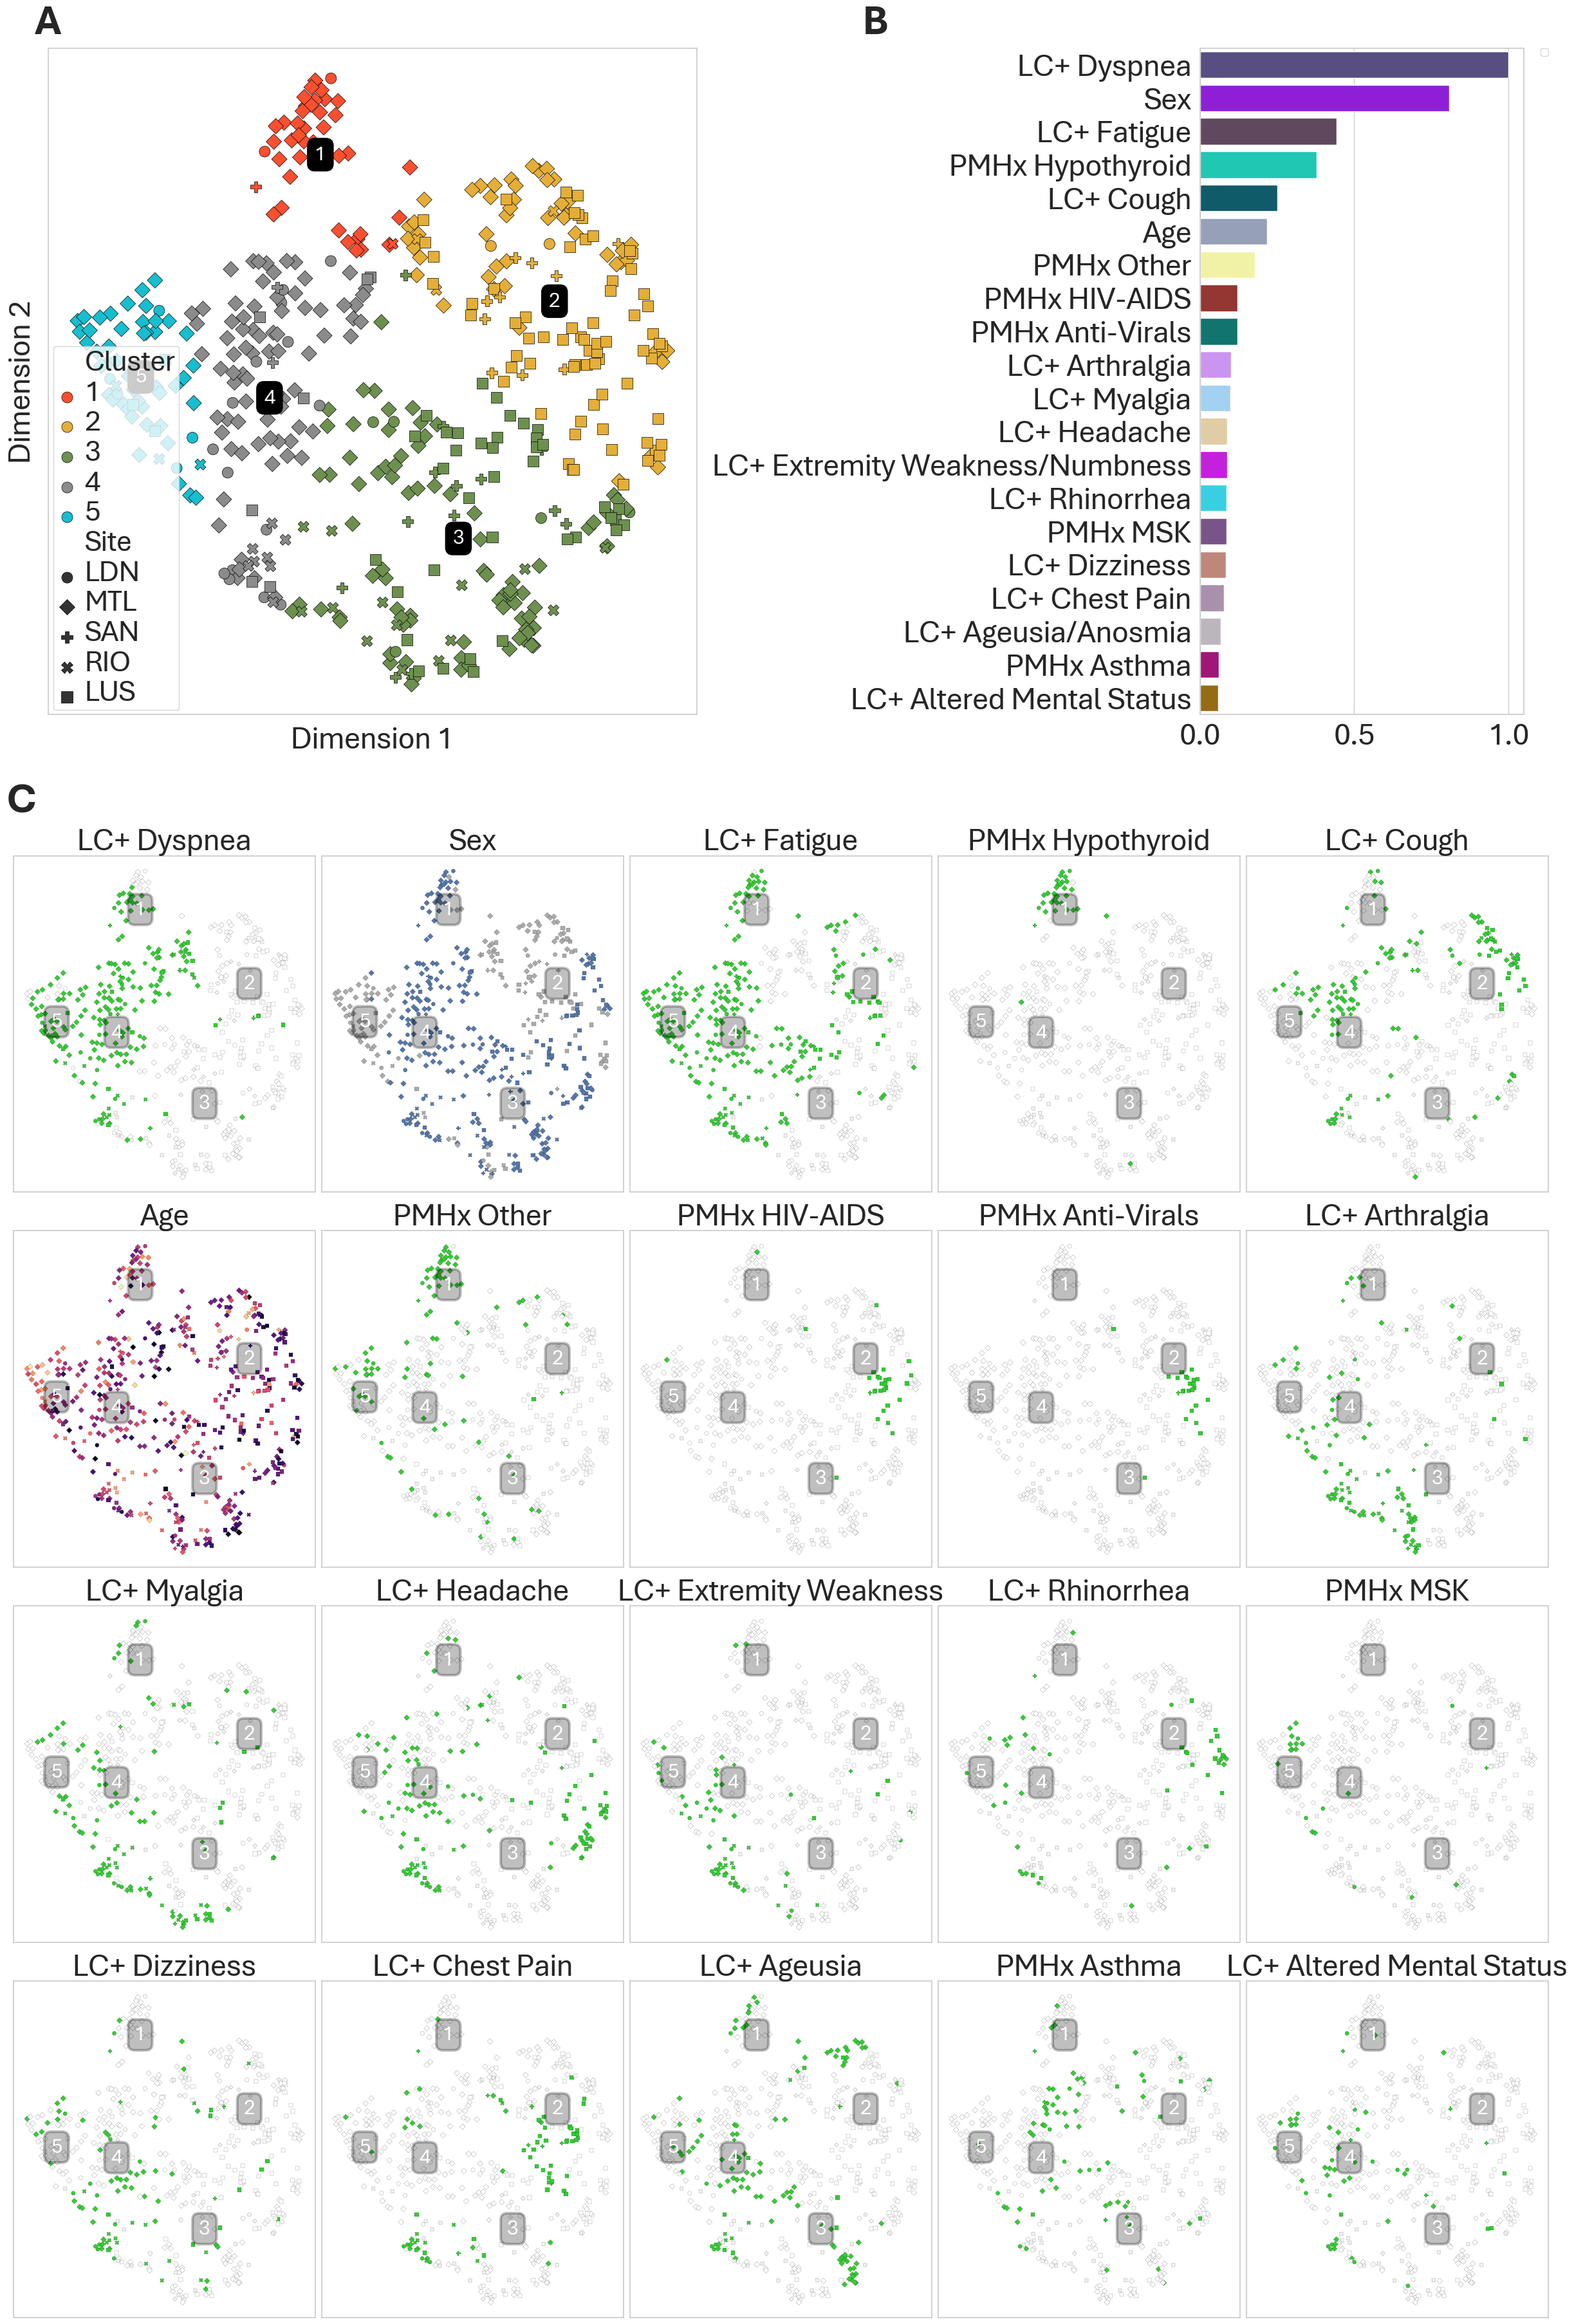

In [48]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              FONTSIZE = FONTSIZE*1.5,
              ax = axs0[0]
              )
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.5)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        fontsize = FONTSIZE*1.5,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

for dpi in [300]:
    fn = f"{figdir}/lc-1028-cluster-feature-importances-{dpi}-{timestamp}.png"
    if SAVE:
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

# if SAVE:
#     # plt.savefig(f"{figdir}/feature-importances-600.png", dpi = 600, bbox_inches = 'tight')
#     plt.savefig(f"{figdir}/feature-importances-300.png", dpi = 300, bbox_inches = 'tight')
#     # plt.savefig(f"{figdir}/feature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
#     # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [49]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
feature_importance_table = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
feature_importance_table["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in feature_importance_table.iterrows():
    if f["Importance"]:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        feature_importance_table.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
feature_importance_table.sort_values(by = "FI", ascending = False, inplace = True)

In [50]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[feature_importance_table["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [51]:
cluster_by_site

Cluster     1     2     3     4     5
Site                                 
LDN       2.0   2.0   5.0  15.0   5.0
MTL      39.0  48.0  82.0  76.0  48.0
SAN       1.0  10.0  13.0   2.0   0.0
RIO       1.0   3.0  14.0   8.0   3.0
LUS       0.0  69.0  38.0   7.0   3.0

In [52]:
cluster_by_site_membership = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cluster_by_site_membership.index.name = "cluster"

# map the site_fullname_dict to the index
cluster_by_site_membership.columns = cluster_by_site_membership.columns.map(site_fullname_dict)
cluster_by_site_membership = cluster_by_site_membership.T
# round to 1 decimal place
cluster_by_site_membership = cluster_by_site_membership.round(1)

cluster_by_site_membership

cluster            1     2     3     4     5
Site                                        
London           6.9   6.9  17.2  51.7  17.2
Montreal        13.3  16.4  28.0  25.9  16.4
San Diego        3.8  38.5  50.0   7.7   0.0
Rio de Janeiro   3.4  10.3  48.3  27.6  10.3
Lusaka           0.0  59.0  32.5   6.0   2.6

In [53]:
feature_prev_by_cluster = M.groupby("cluster").mean()

# get the first 20 columns
feature_prev_by_cluster = feature_prev_by_cluster[feature_importance_table["Feature"][:20]]

# rename the columns
for c in feature_prev_by_cluster.columns:
    feature_prev_by_cluster.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
feature_prev_by_cluster = feature_prev_by_cluster.drop(columns = ["Age", "Sex"])

In [54]:
feature_prev_by_cluster

LC+ Dyspnea  LC+ Fatigue  PMHx Hypothyroid  LC+ Cough  PMHx Other  \
cluster                                                                      
1           0.697674     0.604651          0.697674   0.395349    0.790698   
2           0.151515     0.265152          0.000000   0.356061    0.068182   
3           0.072368     0.355263          0.006579   0.078947    0.085526   
4           0.925926     0.888889          0.009259   0.425926    0.129630   
5           0.847458     1.000000          0.000000   0.152542    0.372881   

         PMHx HIV-AIDS  PMHx Anti-Virals  LC+ Arthralgia  LC+ Myalgia  \
cluster                                                                 
1             0.023256          0.000000        0.162791     0.232558   
2             0.196970          0.174242        0.045455     0.060606   
3             0.006579          0.006579        0.243421     0.256579   
4             0.000000          0.000000        0.314815     0.342593   
5             0.016949          0.000000        0.220339     0.288136   

         LC+ Headache  LC+ Extremity Weakness/Numbness  LC+ Rhinorrhea  \
cluster                                                                  
1            0.162791                         0.046512        0.046512   
2            0.189394                         0.030303        0.151515   
3            0.203947                         0.072368        0.026316   
4            0.453704                         0.324074        0.138889   
5            0.186441                         0.186441        0.084746   

         PMHx MSK  LC+ Dizziness  LC+ Chest Pain  LC+ Ageusia/Anosmia  \
cluster                                                                 
1        0.000000       0.093023        0.046512             0.279070   
2        0.015152       0.068182        0.257576             0.151515   
3        0.013158       0.144737        0.131579             0.269737   
4        0.027778       0.351852        0.212963             0.351852   
5        0.237288       0.254237        0.033898             0.169492   

         PMHx Asthma  LC+ Altered Mental Status  
cluster                                          
1           0.186047                   0.069767  
2           0.083333                   0.030303  
3           0.111842                   0.059211  
4           0.287037                   0.240741  
5           0.067797                   0.169492

/Users/david/projects/lc2-1028/375/2024-08-24/lc-1028-feature-prevalence-by-cluster-300-2024-08-24.png


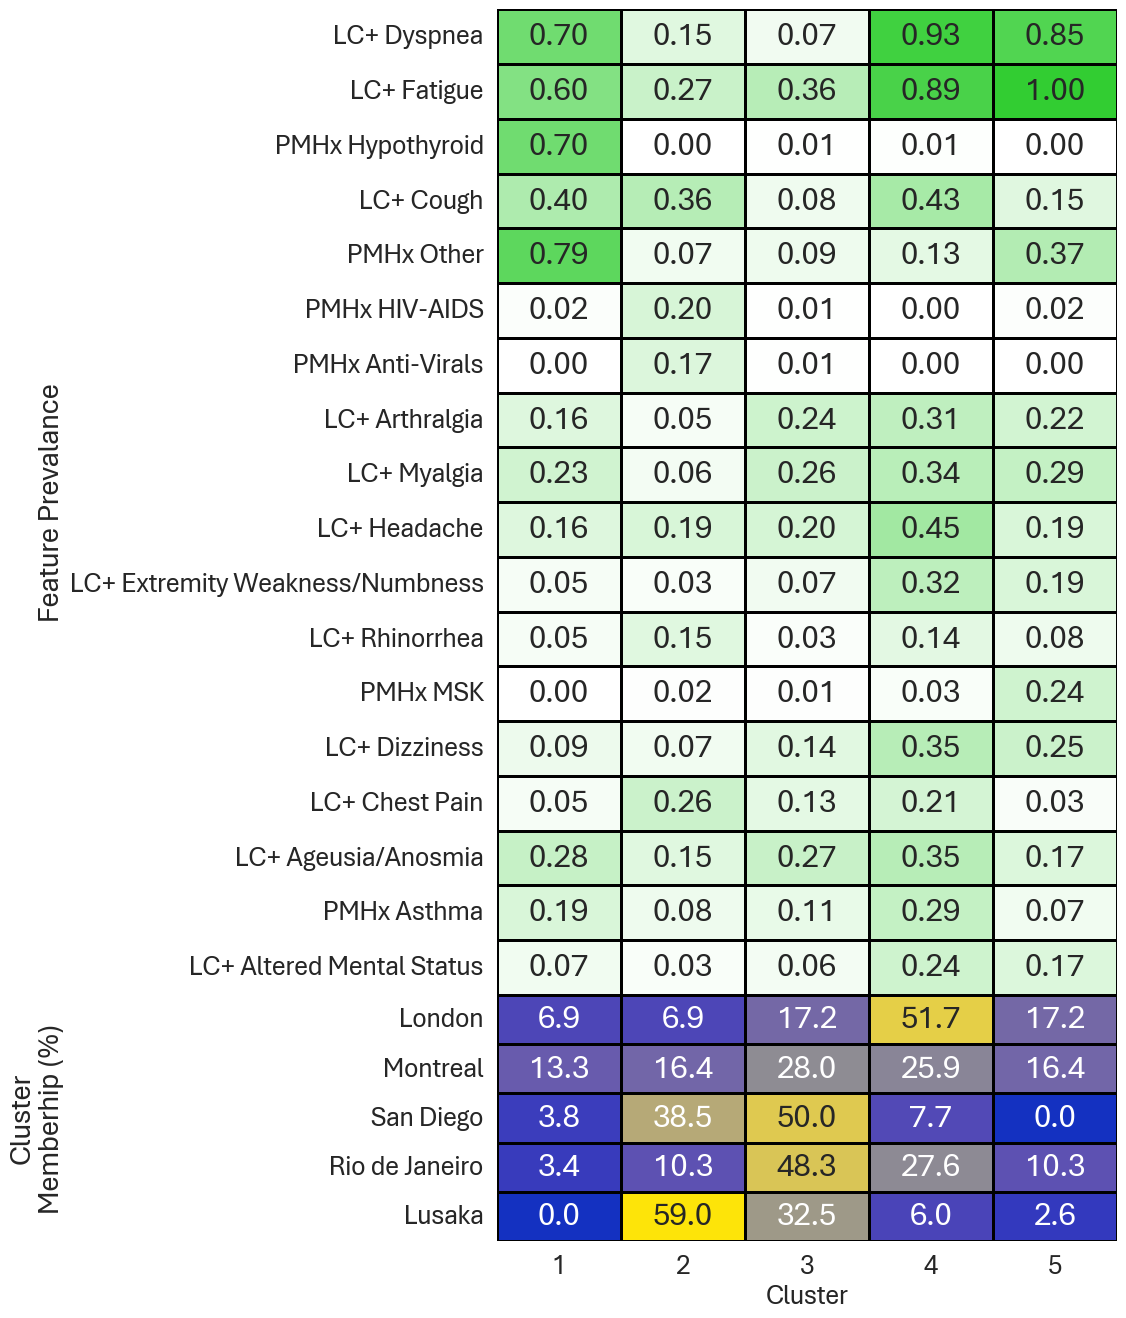

In [55]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(feature_prev_by_cluster.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24}
)

# turn off the xticks and x label
axs0.set_xticks([])
axs0.set_xlabel("")

sns.heatmap(cluster_by_site_membership,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 24}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

for dpi in [300]:
    fn = f"{figdir}/lc-1028-feature-prevalence-by-cluster-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


# By SITE for subphenotypes at each site

In [56]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

In [57]:
# drop columns with NaNs
LC_pos_.dropna(inplace = True, axis = 1)
LC_pos_.shape

(494, 160)

In [58]:
LC_pos_["SITE"] = sites

In [59]:
# cluster pipeline, iterating over the sites

result_dict = {}

items = site_name_dict.items()

# drop LDN from items
# items = list(items)[1:]

for i, (k,v) in enumerate(items):
    # print(i, k, v)

    print("="*50)
    print(f"Site {k}: {v}")
    print("-"*50)

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE =='{v}'").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])
    the_data = the_data.drop(columns = ["SITE"])

    # print(the_data.shape)

    X = scaler.fit_transform(the_data)     # type: ignore
    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    print(f"Min cluster size = {min_cluster_size}")

    # min_cluster_size = 5


    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': 1,
                    # 'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    # 'spread':       5.0,
                    # 'random_state': 42,
                    # 'metric':      'euclidean',
                    # 'metric':      'hamming',
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)


    # get the plot dataframe and cluster labels
    # sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites.loc[X.index], site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 80
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]

    print(f"Important features: {important_features}")

    if len(important_features) == 0:
        print("No important features found.")
        continue


    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
--------------------------------------------------
Data shape = (29, 158)
X shape    = (29, 158)
Min cluster size = 5
Important features: Index(['HHX-Asthma', 'HHX-OTHER-Crohn's-disease', 'HHX-Pregnant',
       'HHX-Psychiatric disease', 'MED-Analgesics', 'MED-Antidepressants',
       'MED-Cardiovascular-agents', 'MED-Hormone-suppressant-(thyroid)',
       'MED-Respiratory-tract-agents', 'SYMPT-abdominal_pain___2',
       'SYMPT-confusion_altered_mental_s___2', 'SYMPT-cough___2',
       'SYMPT-dizziness___2', 'SYMPT-ear_pain___2',
       'SYMPT-extremity_weakness_or_numb___2', 'SYMPT-headache___2',
       'SYMPT-joint_pain_arthralgia___2',
       'SYMPT-loss_of_taste_lost_of_smel___2',
       'SYMPT-muscle_aches_myalgia___2', 'SYMPT-nausea_vomiting___2',
       'SYMPT-night_sweats___2', 'SYMPT-runny_nose_rhinorrhea___2',
       'SYMPT-trouble_speaking_aphasia_d___2'],
      dtype='object')
Site 2: MTL
--------------------------------------------------
Data shape = (293, 158

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/david/projects/lc2-1028/375/2024-08-24/lc-1028-subphenotypes-by-site-300-2024-08-24.png


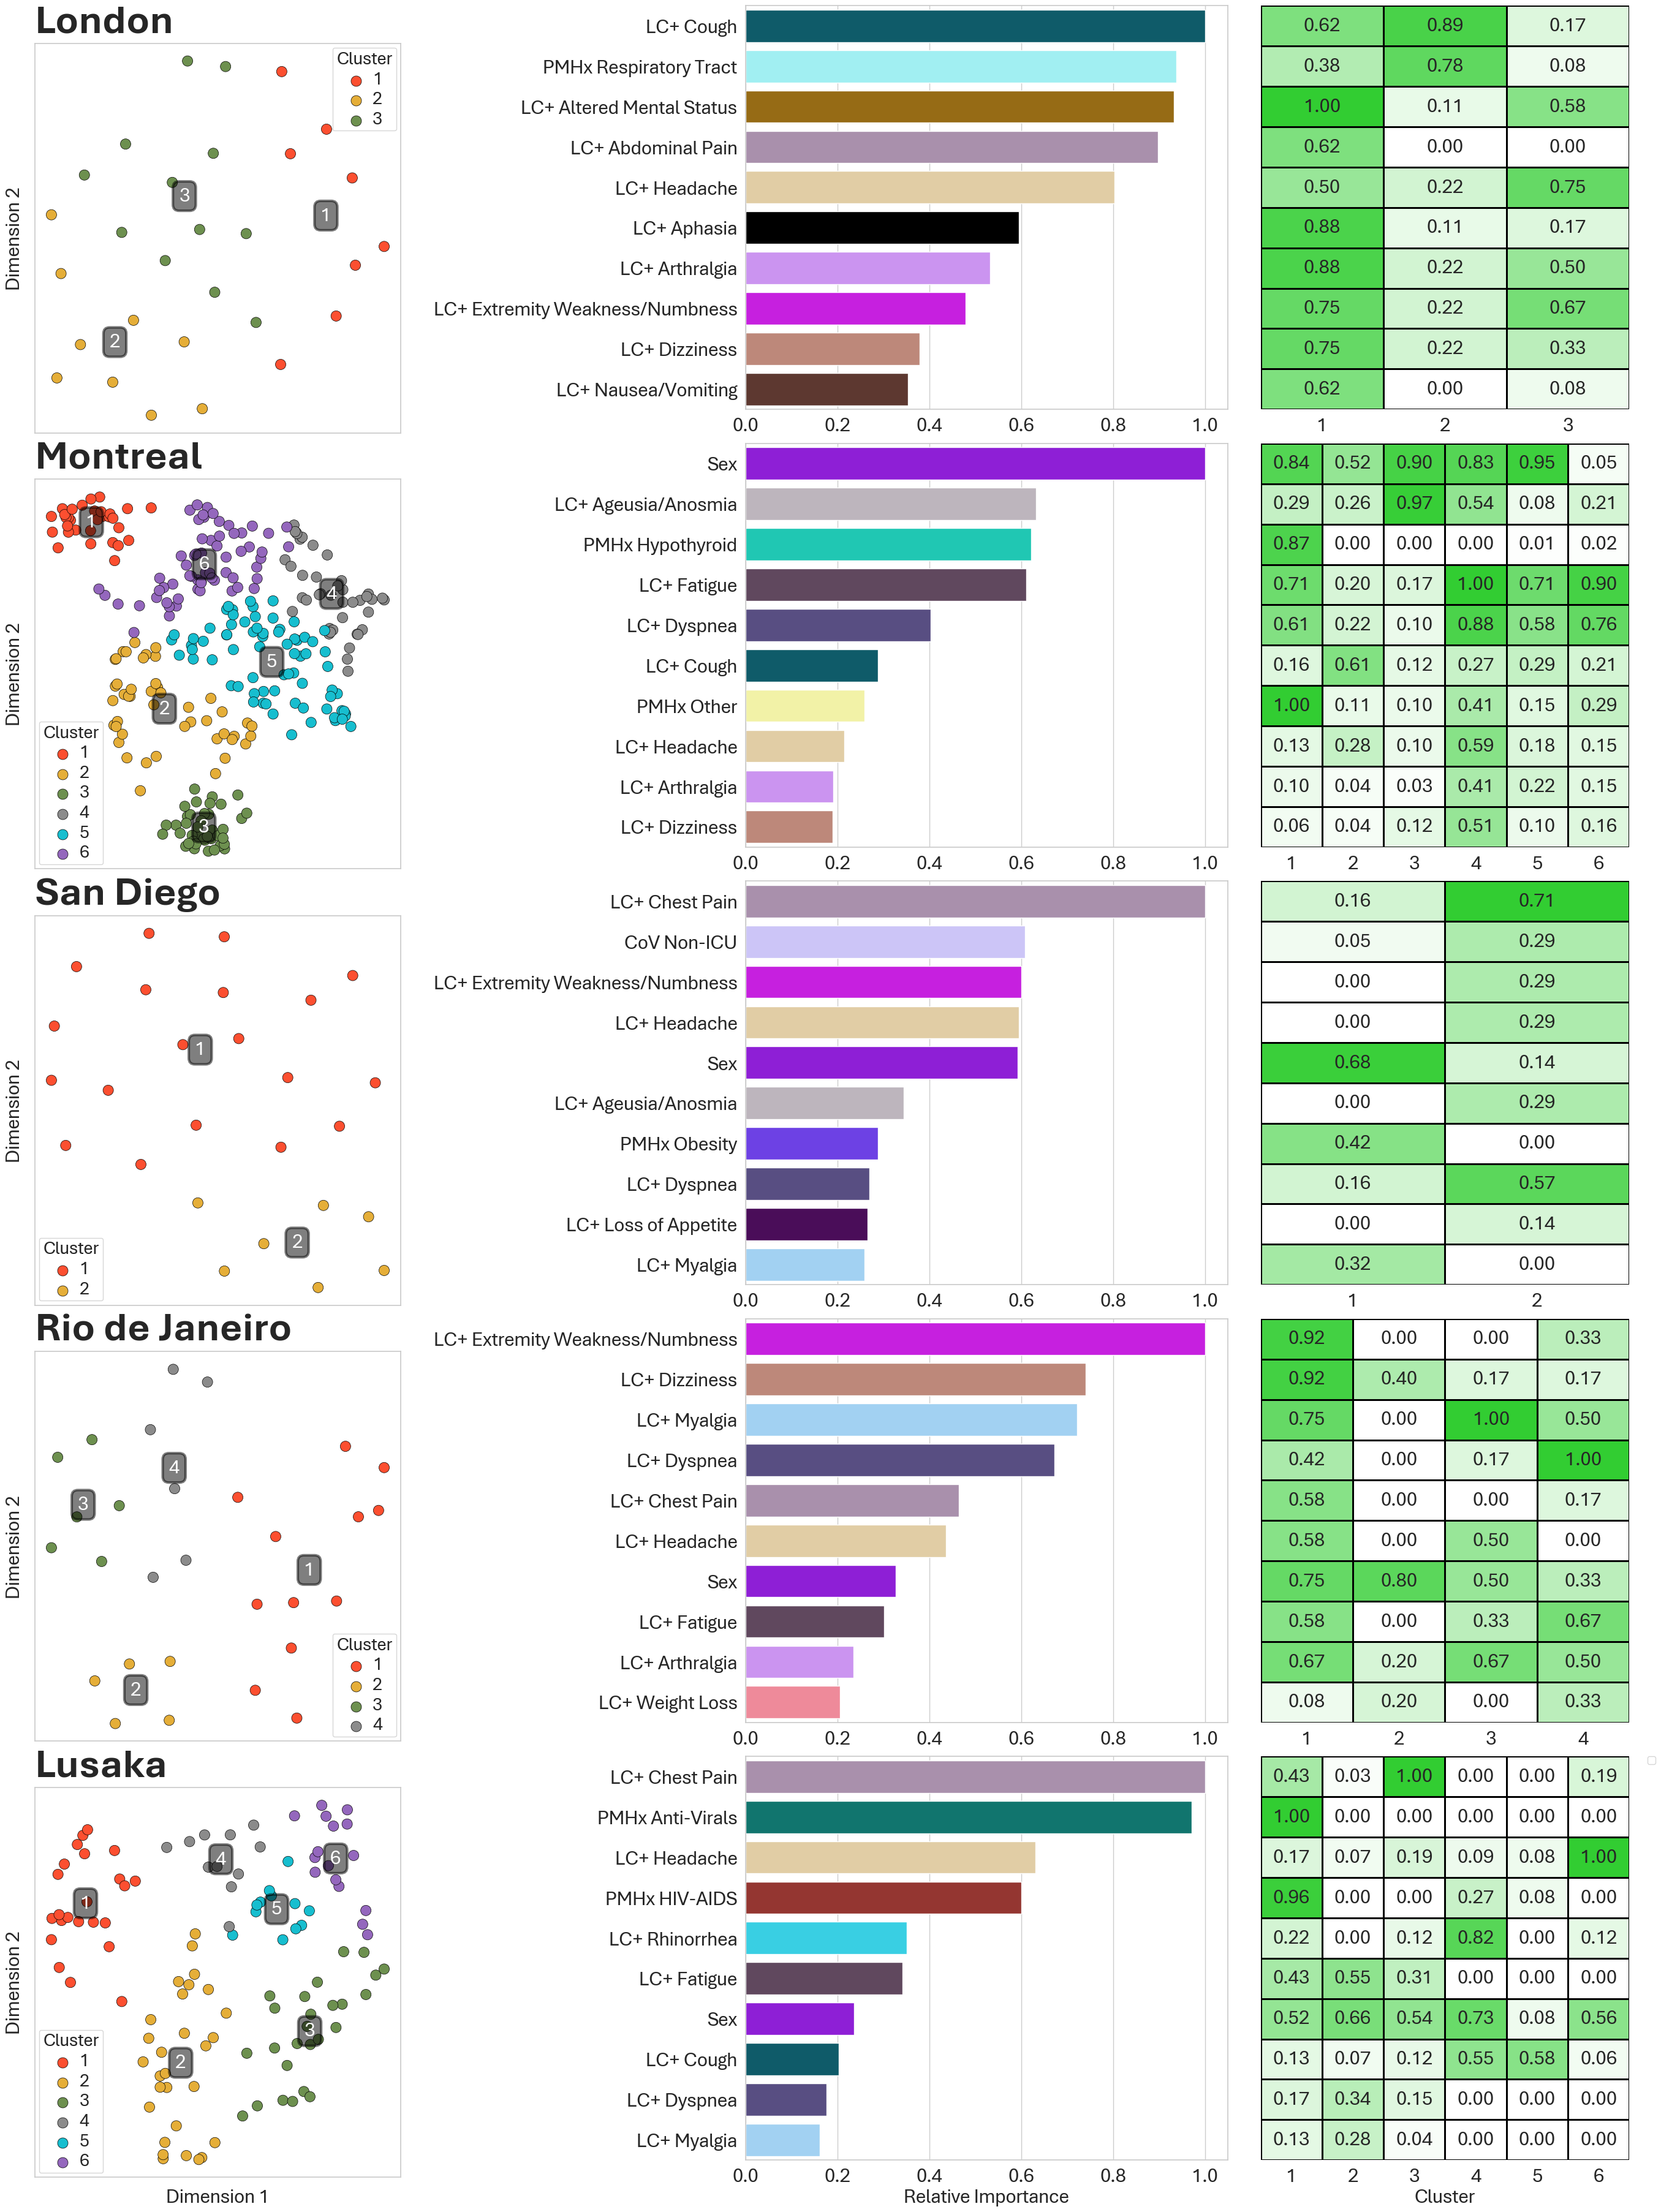

In [60]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = False)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None,
                  centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": True},
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

for dpi in [300]:
    fn = f"{figdir}/lc-1028-subphenotypes-by-site-{dpi}-{timestamp}.png"
    if SAVE:
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')



# By SYMPTOM Status
- new, worsening, etc

In [61]:
# for controlling minimum cluster size
factor = 2

In [62]:
lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

# add age and sex to the list
# lc_symptoms = lc_symptoms + ["age"] + ["sex"]

In [63]:
# select only the features in new_and_worse
X = LC_pos_[lc_symptoms].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
# X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(494, 28)
(494, 28)
(494, 28)


In [64]:
# # drop certain features

# # drop features that contain adjunctive
# X = X.drop(columns = X.filter(regex = 'adjunctive').columns)

# # drop features that contain "medication_received"
# X = X.drop(columns = X.filter(regex = 'medication_received').columns)

# # drop features that contain "type_of_care"
# X = X.drop(columns = X.filter(regex = 'type_of_care').columns)

# # drop features that contain "ventilatory_support_type"
# # X = X.drop(columns = X.filter(regex = 'ventilatory_support_type').columns)

# print(X.shape)

In [65]:
# scale the features using minmax scaler
X = scaler.fit_transform(X)

In [66]:
# cluster pipeline


min_cluster_size = int(np.sqrt(X.shape[0]))*factor

print(f"MCS = {min_cluster_size}")



hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples':      1,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                # 'spread':       1.0,
                'random_state': 42,
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
# sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

n_clust = max(cluster_labels)+1

MCS = 44
UMAP(random_state=42, verbose=True)
Sat Aug 24 23:07:10 2024 Construct fuzzy simplicial set
Sat Aug 24 23:07:10 2024 Finding Nearest Neighbors
Sat Aug 24 23:07:10 2024 Finished Nearest Neighbor Search
Sat Aug 24 23:07:10 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Aug 24 23:07:12 2024 Finished embedding


In [67]:
plot_df

x          y  Cluster  Cluster Confidence Site
0     3.726345  25.362431        4            1.000000  LDN
1     4.720122  25.912607        4            1.000000  LDN
2     4.488359  26.424986        4            0.964112  LDN
3     3.117357  24.256180        5            1.000000  LDN
4     1.861427  28.625160        7            1.000000  LDN
..         ...        ...      ...                 ...  ...
978  13.061936  22.278919        1            0.802420  LUS
979  15.049050  24.261078        3            1.000000  LUS
980  14.699624  21.831154        1            0.890885  LUS
981  12.622512  21.571154        1            1.000000  RIO
982   4.210674  26.072025        4            1.000000  RIO

[494 rows x 5 columns]

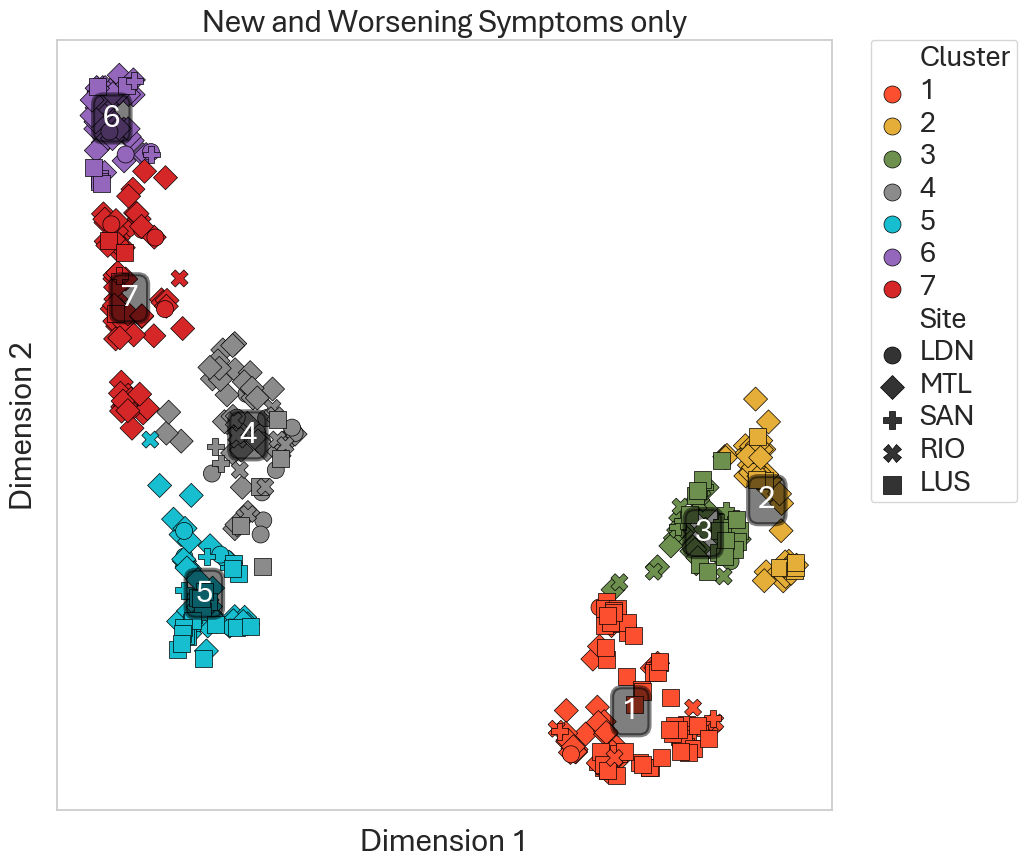

In [68]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = "New and Worsening Symptoms only", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": True},)


In [69]:
# prepare to export the plot_df

# join sl_df to plot_df
plot_df = plot_df.join(sl_df, how = "inner")

# make a copy that excludes x and y
plot_df2 = plot_df.drop(columns = ["x", "y", "Cluster Confidence"])

# save as an excel fdile
plot_df2.to_excel(figdir / f"lc-1028-SYMPT-clusters-with-sample-label-id-{timestamp}.xlsx")

In [94]:
figdir

PosixPath('/Users/david/projects/lc2-1028/375/2024-08-24')

In [70]:
plot_df

x          y  Cluster  Cluster Confidence Site Sample_Label_ID
0     3.726345  25.362431        4            1.000000  LDN        LDN-0001
1     4.720122  25.912607        4            1.000000  LDN        LDN-0002
2     4.488359  26.424986        4            0.964112  LDN        LDN-0003
3     3.117357  24.256180        5            1.000000  LDN        LDN-0004
4     1.861427  28.625160        7            1.000000  LDN        LDN-0005
..         ...        ...      ...                 ...  ...             ...
978  13.061936  22.278919        1            0.802420  LUS        LUS-0353
979  15.049050  24.261078        3            1.000000  LUS        LUS-0174
980  14.699624  21.831154        1            0.890885  LUS        LUS-0319
981  12.622512  21.571154        1            1.000000  RIO        RIO-0074
982   4.210674  26.072025        4            1.000000  RIO        RIO-0100

[494 rows x 6 columns]

In [96]:
# find sapmle_label_id that startswith SAN-0055
san_0055 = plot_df.query("Sample_Label_ID.str.startswith('SAN-0055')", engine = "python")
san_0055

x          y  Cluster  Cluster Confidence Site Sample_Label_ID  \
738  4.084836  24.112074        5            0.634576  SAN        SAN-0055   

    SYMPT-fatigue___2 SYMPT-shortness_of_breath_dyspne___2  \
738           Present                               Absent   

    SYMPT-loss_of_taste_lost_of_smel___2 SYMPT-cough___2  \
738                               Absent          Absent   

    SYMPT-muscle_aches_myalgia___2 SYMPT-joint_pain_arthralgia___2  \
738                        Present                          Absent   

    SYMPT-chest_pain___2 SYMPT-headache___2 SYMPT-dizziness___2  \
738               Absent             Absent              Absent   

    SYMPT-extremity_weakness_or_numb___2  
738                               Absent

In [71]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

In [81]:
cluster_by_site

cluster          1          2          3          4          5          6  \
Site                                                                        
LDN       6.896552   0.000000   3.448276  44.827586  17.241379  10.344828   
LUS      51.282051   5.982906  13.675214   4.273504  17.094017   5.128205   
MTL      12.969283  16.382253   6.825939  12.286689  13.993174  15.358362   
RIO      13.793103   3.448276  34.482759  37.931034   3.448276   3.448276   
SAN      23.076923   0.000000  38.461538   7.692308  19.230769   7.692308   

cluster          7  
Site                
LDN      17.241379  
LUS       2.564103  
MTL      22.184300  
RIO       3.448276  
SAN       3.846154

In [72]:
# # sort by order in site_name_dict
# cbs = cbs.loc[site_name_dict.values()]

# # rename index values using site_fullname_dict
# cbs.index = cbs.index.map(site_fullname_dict)
# cbs = cbs.astype(int)

# cbs.to_latex(f"{reportdir}/SYMPT_2-cluster-by-site-{n_clust}.tex")

In [73]:
cluster_by_site_membership = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cluster_by_site_membership.index.name = "cluster"

# map the site_fullname_dict to the index
cluster_by_site_membership.columns = cluster_by_site_membership.columns.map(site_fullname_dict)
cluster_by_site_membership = cluster_by_site_membership.T
# round to 1 decimal place
cluster_by_site_membership = cluster_by_site_membership.round(1)

# sort by the order in site_name_dict
cluster_by_site_membership = cluster_by_site_membership.loc[site_fullname_dict.values()]

cluster_by_site_membership

cluster            1     2     3     4     5     6     7
Site                                                    
London           6.9   0.0   3.4  44.8  17.2  10.3  17.2
Montreal        13.0  16.4   6.8  12.3  14.0  15.4  22.2
San Diego       23.1   0.0  38.5   7.7  19.2   7.7   3.8
Rio de Janeiro  13.8   3.4  34.5  37.9   3.4   3.4   3.4
Lusaka          51.3   6.0  13.7   4.3  17.1   5.1   2.6

In [74]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 80
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100


BorutaPy finished running.

Iteration: 	23 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	16


RandomForestClassifier(max_depth=7, n_estimators=72, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x312CEEC40)

In [75]:
# dataframes with the feature importance and topN features

topN = 10

fi_df = make_feature_importance_df(clf2, important_features)
top_features = make_topN_features(fi_df, topN, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/david/projects/lc2-1028/375/2024-08-24/lc-1028-SYMPT-feature-importances-by-cluster-7-300-2024-08-24.png


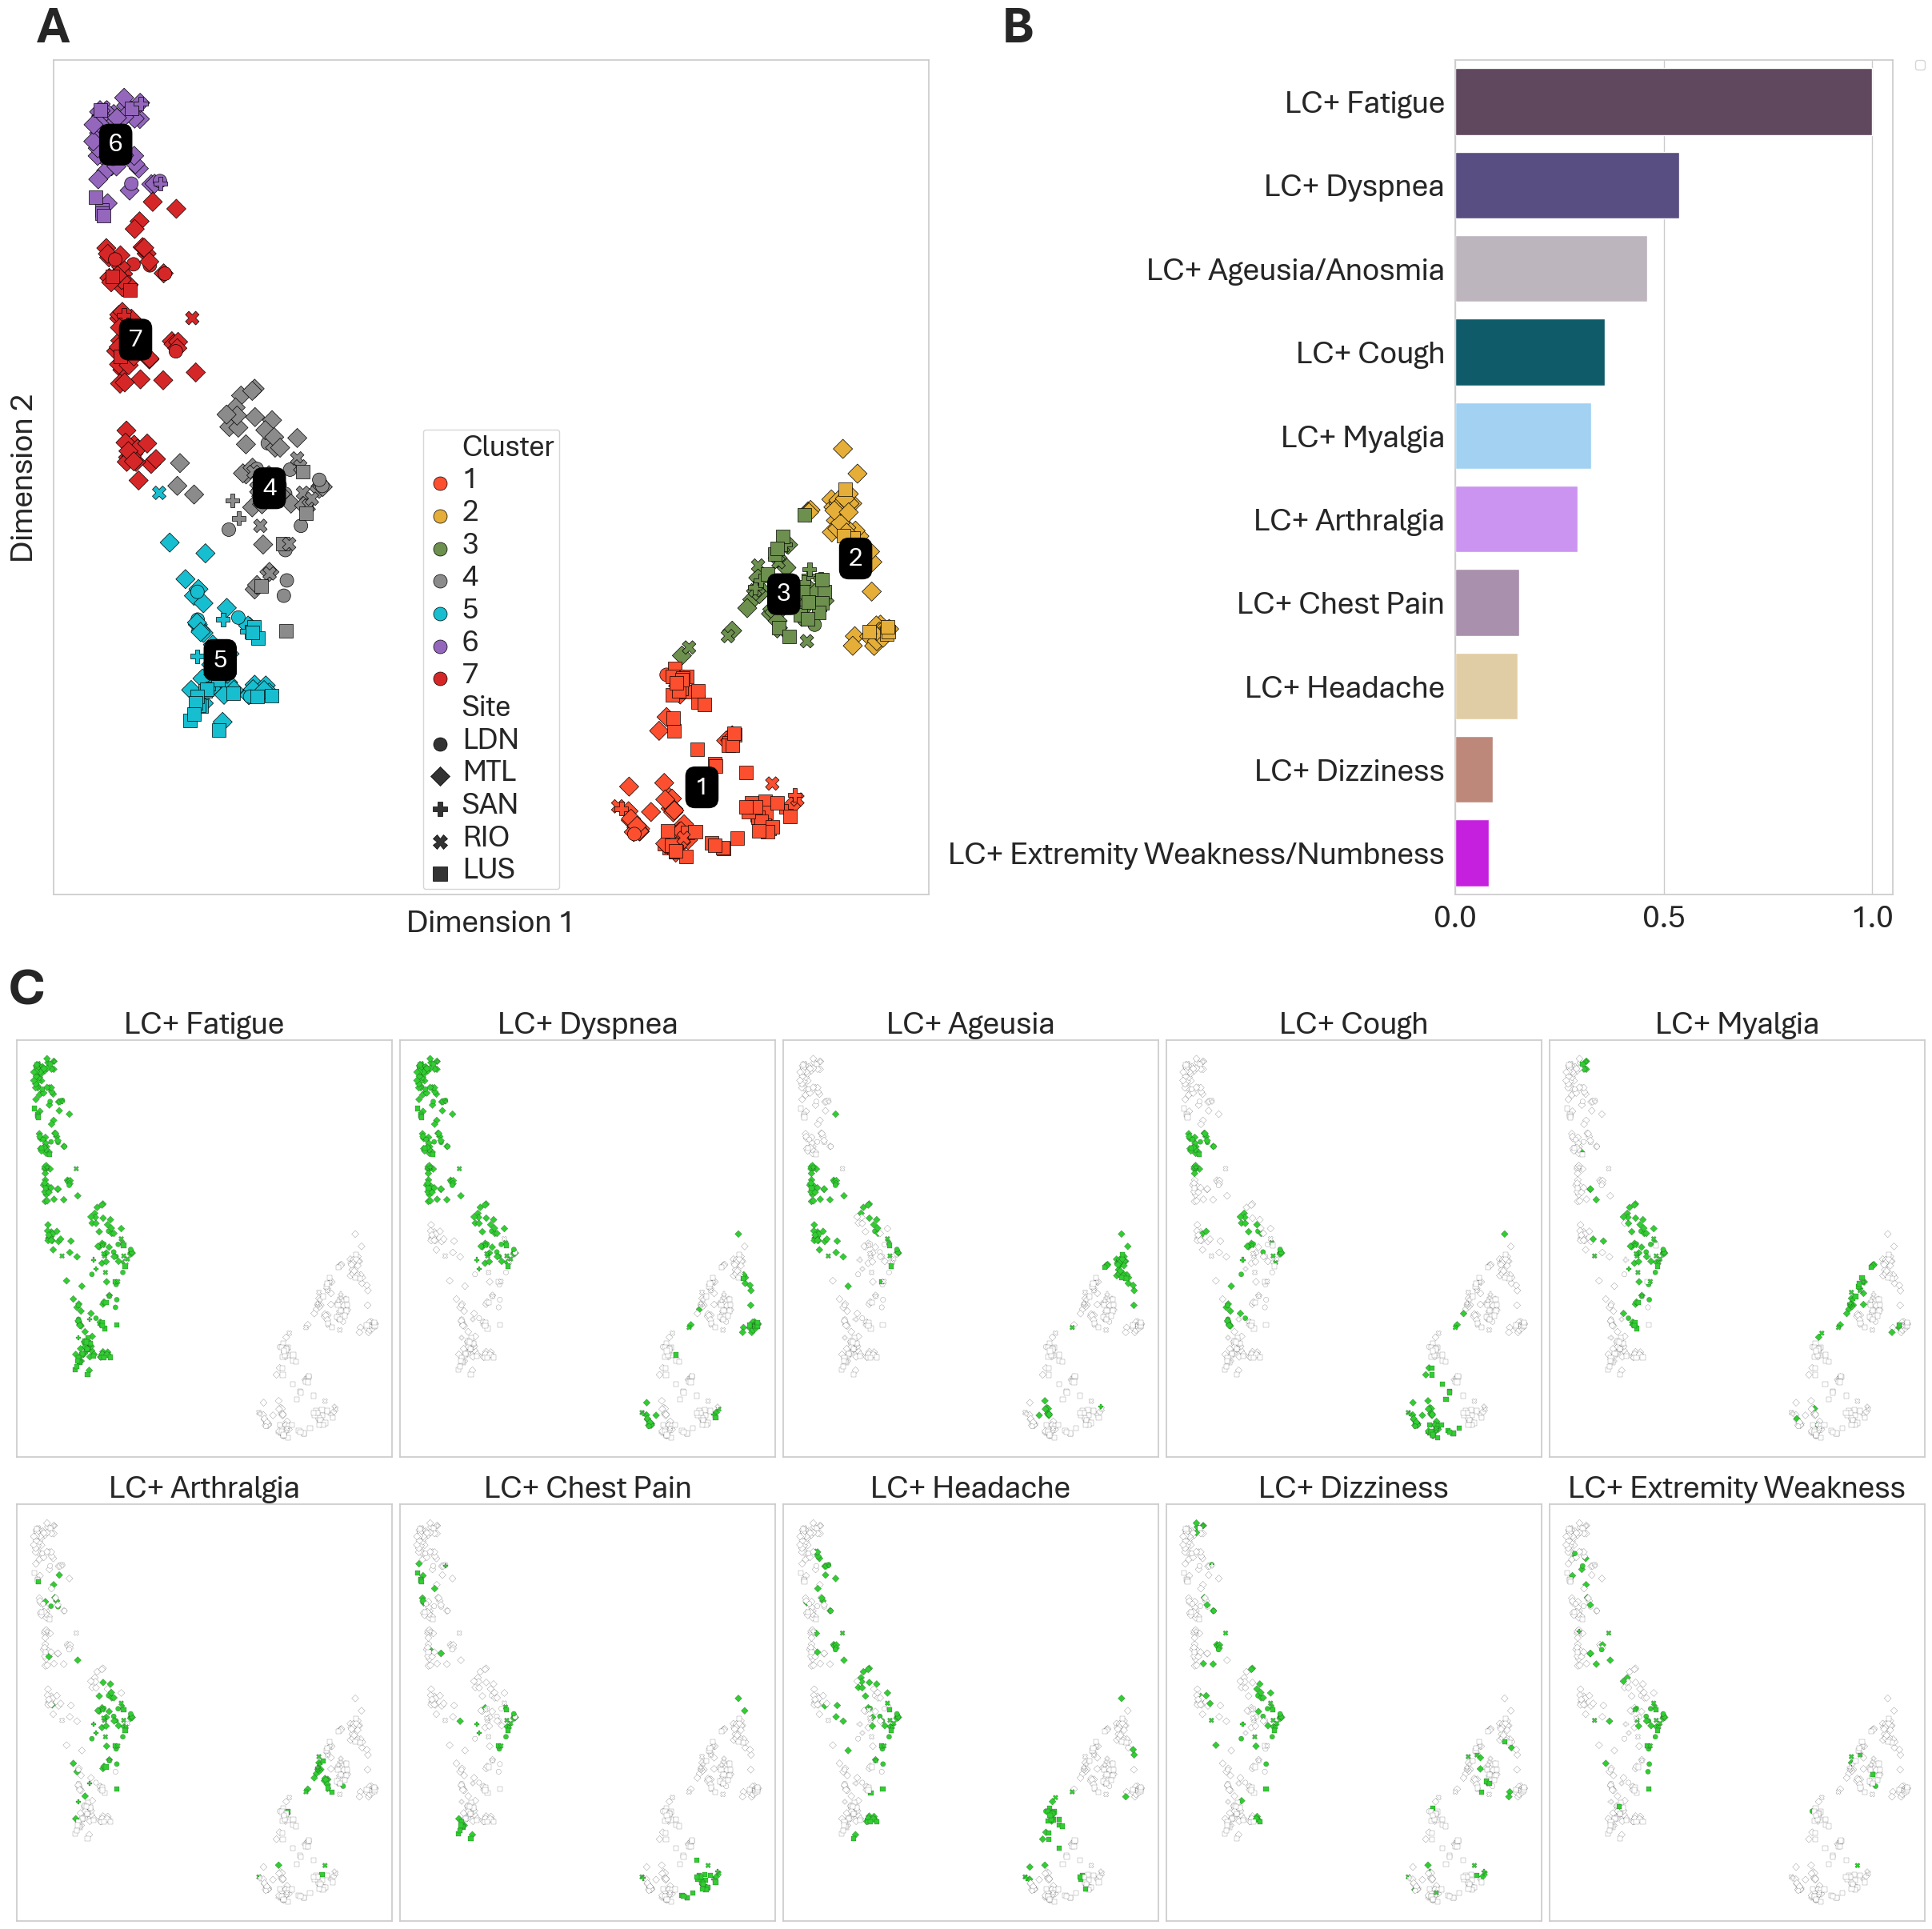

In [76]:
# plot

# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)
n_rows = int(np.ceil(n/5))

# if n_rows == 1:
#     ht_ratio = 0.5
#     ht = 24
# else:
#     ht_ratio = 2
#     ht = 36

ht = 24
ht_ratio = 2

height_ratios = [1,1]

# h_factor = 

fig     = plt.figure(layout="constrained", figsize=(24,ht))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=height_ratios, hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.25,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)

axs1 = subfigs[1].subplots(n_rows,5)

plot_multiple_features(fi_df[:topN], 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        fontsize = int(FONTSIZE*1.25),

                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

for dpi in [300]:
    fn = f"{figdir}/lc-1028-SYMPT-feature-importances-by-cluster-{n_clust}-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

# if SAVE:
#     plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/SYMPT_2-only-ffeature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

In [77]:
# heatmap of features by cluster
M = X.copy()
M = M[important_features]
M["cluster"] = [c+1 for c in cluster_labels]
# M = M.drop(columns = ["Age", "Sex"])

# get the means
mfv = M.groupby("cluster").mean()

# sort the index by the order in fi_df
mfv = mfv[fi_df["Feature"]]

# transpose
mfv = mfv.T

# rename mfv index
mfv.index = mfv.index.map(feature_map)

# remove rows with index ["Age", "Sex"]

# drop a row by index

for c in ["Age", "Sex"]:

    try:
        mfv = mfv.drop(index = [c])
    except KeyError:
        print(f"Column {c} is not in the data")

# try:
#     mfv = mfv.drop(index = ["Sex"])
# except KeyError:
#     pass


Column Age is not in the data
Column Sex is not in the data


In [78]:
mfv

cluster                                 1         2         3         4  \
LC+ Fatigue                      0.000000  0.000000  0.000000  0.985075   
LC+ Dyspnea                      0.172727  0.500000  0.052632  0.686567   
LC+ Ageusia/Anosmia              0.090909  0.642857  0.035088  0.358209   
LC+ Cough                        0.500000  0.017857  0.052632  0.388060   
LC+ Myalgia                      0.027273  0.107143  0.456140  0.850746   
LC+ Arthralgia                   0.054545  0.000000  0.385965  0.776119   
LC+ Chest Pain                   0.327273  0.035714  0.000000  0.298507   
LC+ Headache                     0.300000  0.071429  0.052632  0.626866   
LC+ Dizziness                    0.100000  0.089286  0.157895  0.507463   
LC+ Extremity Weakness/Numbness  0.036364  0.000000  0.087719  0.492537   
LC+ Rhinorrhea                   0.154545  0.017857  0.017544  0.194030   
LC+ Altered Mental Status        0.009091  0.017857  0.087719  0.328358   

cluster                                 5         6         7  
LC+ Fatigue                      1.000000  1.000000  1.000000  
LC+ Dyspnea                      0.000000  1.000000  0.773333  
LC+ Ageusia/Anosmia              0.027778  0.000000  0.626667  
LC+ Cough                        0.180556  0.000000  0.440000  
LC+ Myalgia                      0.125000  0.087719  0.066667  
LC+ Arthralgia                   0.083333  0.017544  0.133333  
LC+ Chest Pain                   0.138889  0.122807  0.080000  
LC+ Headache                     0.208333  0.140351  0.240000  
LC+ Dizziness                    0.111111  0.105263  0.200000  
LC+ Extremity Weakness/Numbness  0.055556  0.105263  0.146667  
LC+ Rhinorrhea                   0.069444  0.052632  0.080000  
LC+ Altered Mental Status        0.083333  0.140351  0.120000

/Users/david/projects/lc2-1028/375/2024-08-24/lc-1028-SYMPT-feature-prevalence-by-cluster-7-300-2024-08-24.png


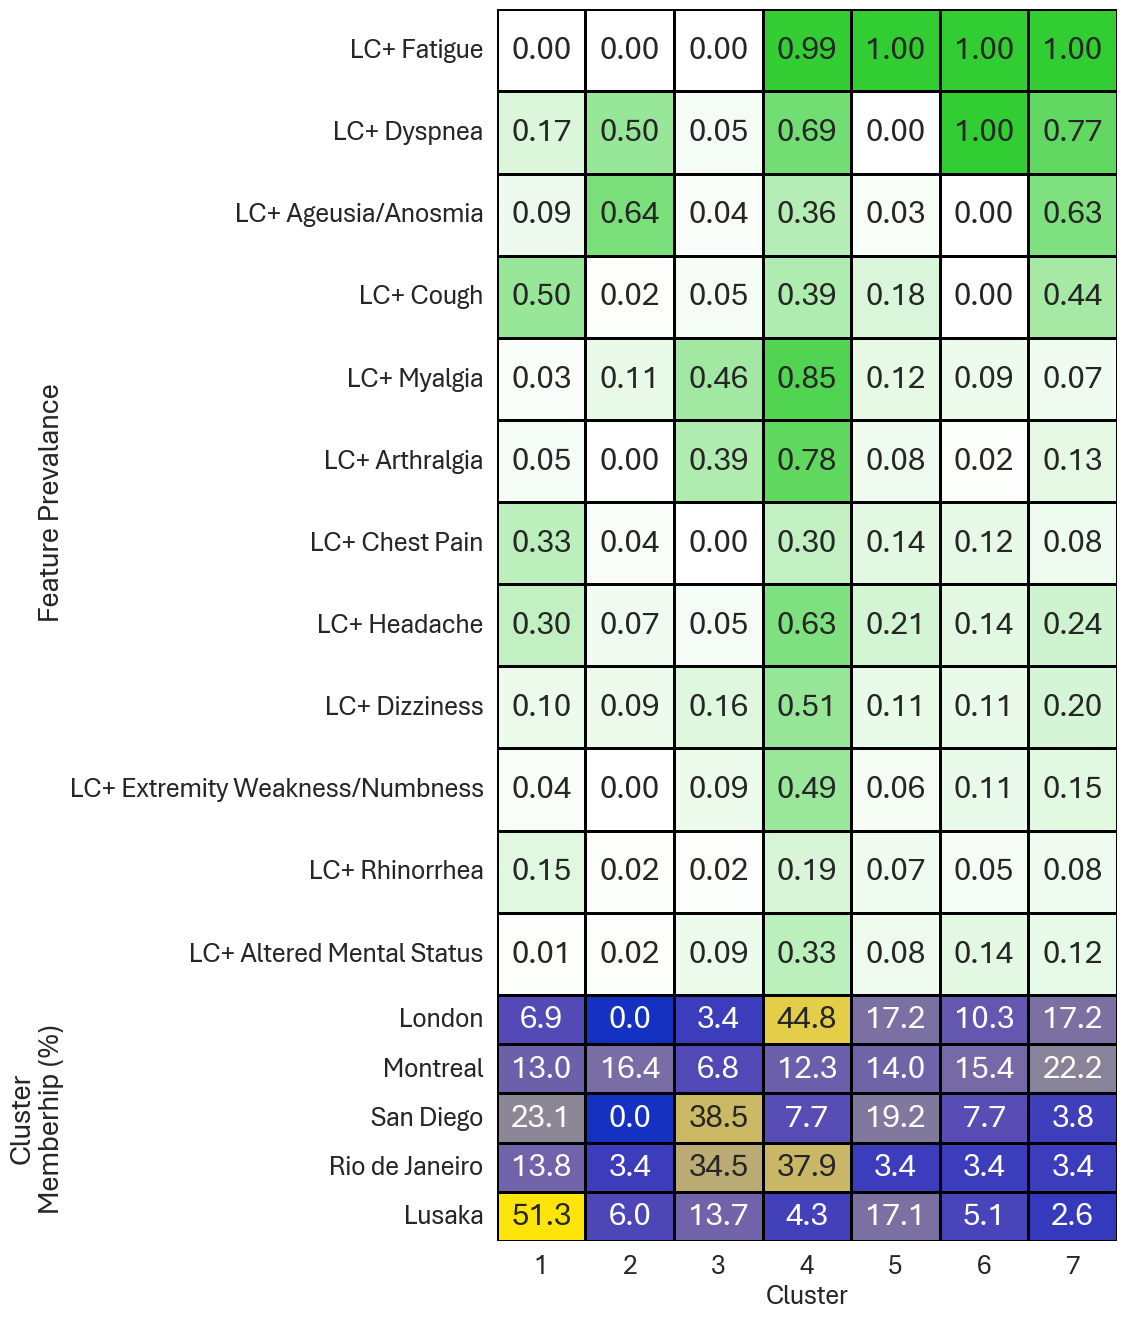

In [79]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

# logscale the heatmap colour
# cmap = sns.color_palette("viridis", as_cmap = True)

# from matplotlib.colors import LogNorm

sns.heatmap(mfv[:20], 
            cmap = cmap, 
            # norm = LogNorm(),
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24}
)

# turn off the xticks and x label
axs0.set_xticks([]) 
axs0.set_xlabel("")

sns.heatmap(cluster_by_site_membership,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            # norm = LogNorm(),
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 24}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure

for dpi in [300]:
    fn = f"{figdir}/lc-1028-SYMPT-feature-prevalence-by-cluster-{n_clust}-{dpi}-{timestamp}.png"
    if SAVE:
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')



In [80]:
# TODO: read the 5500 data set, select only the 1028 indices, and compare that with the 1028 data set


In [82]:
# df

In [84]:
LC_pos_

CD-acute_kidney_injury___2  CD-acute_respiratory_distress___2  \
0                           0.0                                0.0   
1                           0.0                                0.0   
2                           0.0                                0.0   
3                           0.0                                0.0   
4                           0.0                                0.0   
..                          ...                                ...   
978                         0.0                                0.0   
979                         0.0                                0.0   
980                         0.0                                0.0   
981                         0.0                                0.0   
982                         0.0                                0.0   

     CD-anemia___2  CD-anxiety___2  CD-asthma___2  \
0              0.0             0.0            0.0   
1              0.0             0.0            0.0   
2              0.0             0.0            0.0   
3              0.0             0.0            0.0   
4              0.0             0.0            0.0   
..             ...             ...            ...   
978            0.0             0.0            0.0   
979            0.0             0.0            0.0   
980            0.0             0.0            0.0   
981            0.0             0.0            0.0   
982            0.0             0.0            0.0   

     CD-bacterial_viral_or_cryptog___2  CD-bacteriemia___2  CD-brain_fog___2  \
0                                  0.0                 0.0               0.0   
1                                  0.0                 0.0               0.0   
2                                  0.0                 0.0               0.0   
3                                  0.0                 0.0               0.0   
4                                  0.0                 0.0               0.0   
..                                 ...                 ...               ...   
978                                0.0                 0.0               0.0   
979                                0.0                 0.0               0.0   
980                                0.0                 0.0               0.0   
981                                0.0                 0.0               0.0   
982                                0.0                 0.0               0.0   

     CD-bronchiolitis___2  CD-cardiac_arrest___2  ...  \
0                     0.0                    0.0  ...   
1                     0.0                    0.0  ...   
2                     0.0                    0.0  ...   
3                     0.0                    0.0  ...   
4                     0.0                    0.0  ...   
..                    ...                    ...  ...   
978                   0.0                    0.0  ...   
979                   0.0                    0.0  ...   
980                   0.0                    0.0  ...   
981                   0.0                    0.0  ...   
982                   0.0                    0.0  ...   

     SYMPT-runny_nose_rhinorrhea___2  SYMPT-seizure___2  \
0                                1.0                0.0   
1                                0.0                0.0   
2                                0.0                0.0   
3                                0.0                0.0   
4                                0.0                0.0   
..                               ...                ...   
978                              1.0                0.0   
979                              0.0                0.0   
980                              0.0                0.0   
981                              0.0                0.0   
982                              0.0                0.0   

     SYMPT-shortness_of_breath_dyspne___2  SYMPT-skin_rash___2  \
0                                     0.0                  0.0   
1                                     1.

In [92]:
LC_pos

sex   age  SITE  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
0    1.0  47.0   1.0                       0.0                       1.0   
1    2.0  37.0   1.0                       0.0                       0.0   
2    2.0  54.0   1.0                       0.0                       0.0   
3    1.0  78.0   1.0                       0.0                       0.0   
4    2.0  33.0   1.0                       0.0                       0.0   
..   ...   ...   ...                       ...                       ...   
489  1.0  25.0   5.0                       0.0                       0.0   
490  1.0  51.0   5.0                       0.0                       0.0   
491  1.0  50.0   5.0                       0.0                       0.0   
492  1.0  71.0   4.0                       0.0                       0.0   
493  2.0  68.0   4.0                       0.0                       0.0   

     SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
0                     0.0                   0.0   
1                     0.0                   0.0   
2                     0.0                   0.0   
3                     0.0                   0.0   
4                     1.0                   0.0   
..                    ...                   ...   
489                   1.0                   0.0   
490                   0.0                   0.0   
491                   1.0                   1.0   
492                   0.0                   0.0   
493                   0.0                   0.0   

     SYMPT-confusion_altered_mental_s___1  \
0                                     0.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   
..                                    ...   
489                                   0.0   
490                                   0.0   
491                                   0.0   
492                                   0.0   
493                                   0.0   

     SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
0                                     1.0              1.0  ...   
1                                     0.0              1.0  ...   
2                                     1.0              1.0  ...   
3                                     0.0              0.0  ...   
4                                     1.0              1.0  ...   
..                                    ...              ...  ...   
489                                   0.0              1.0  ...   
490                                   0.0              0.0  ...   
491                                   0.0              1.0  ...   
492                                   0.0              0.0  ...   
493                                   0.0              0.0  ...   

     MED-Dermatological-agents  MED-Gastrointestinal-agents  \
0                            0                            1   
1                            0                            0   
2                            0                            0   
3                            0                            1   
4                            0                            0   
..                         ...                          ...   
489                          0                            0   
490                          0                            0   
491                          0                            0   
492                          0                            0   
493                          0                            0   

     MED-Hormonal-agents-(sex-hormones)  MED-Hormonal-agents-(thyroid)  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              1   
3                                     0                              0   
4     

In [93]:
# rename Sample_Label to SL
LC_pos = LC_pos.rename(columns = {"Sample_Label_ID": "SL"})

# reset the index
LC_pos = LC_pos.reset_index(drop = True)

# assing SL as the index
LC_pos = LC_pos.set_index("SL")

LC_pos

sex   age  SITE  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
SL                                                                              
LDN-0001  1.0  47.0   1.0                       0.0                       1.0   
LDN-0002  2.0  37.0   1.0                       0.0                       0.0   
LDN-0003  2.0  54.0   1.0                       0.0                       0.0   
LDN-0004  1.0  78.0   1.0                       0.0                       0.0   
LDN-0005  2.0  33.0   1.0                       0.0                       0.0   
...       ...   ...   ...                       ...                       ...   
LUS-0353  1.0  25.0   5.0                       0.0                       0.0   
LUS-0174  1.0  51.0   5.0                       0.0                       0.0   
LUS-0319  1.0  50.0   5.0                       0.0                       0.0   
RIO-0074  1.0  71.0   4.0                       0.0                       0.0   
RIO-0100  2.0  68.0   4.0                       0.0                       0.0   

          SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
SL                                                     
LDN-0001                   0.0                   0.0   
LDN-0002                   0.0                   0.0   
LDN-0003                   0.0                   0.0   
LDN-0004                   0.0                   0.0   
LDN-0005                   1.0                   0.0   
...                        ...                   ...   
LUS-0353                   1.0                   0.0   
LUS-0174                   0.0                   0.0   
LUS-0319                   1.0                   1.0   
RIO-0074                   0.0                   0.0   
RIO-0100                   0.0                   0.0   

          SYMPT-confusion_altered_mental_s___1  \
SL                                               
LDN-0001                                   0.0   
LDN-0002                                   1.0   
LDN-0003                                   1.0   
LDN-0004                                   0.0   
LDN-0005                                   1.0   
...                                        ...   
LUS-0353                                   0.0   
LUS-0174                                   0.0   
LUS-0319                                   0.0   
RIO-0074                                   0.0   
RIO-0100                                   0.0   

          SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
SL                                                               ...   
LDN-0001                                   1.0              1.0  ...   
LDN-0002                                   0.0              1.0  ...   
LDN-0003                                   1.0              1.0  ...   
LDN-0004                                   0.0              0.0  ...   
LDN-0005                                   1.0              1.0  ...   
...                                        ...              ...  ...   
LUS-0353                                   0.0              1.0  ...   
LUS-0174                                   0.0              0.0  ...   
LUS-0319                                   0.0              1.0  ...   
RIO-0074                                   0.0              0.0  ...   
RIO-0100                                   0.0              0.0  ...   

          MED-Cardiovascular-agents  MED-Dermatological-agents  \
SL                                                               
LDN-0001                          0                          0   
LDN-0002                          1                          0   
LDN-0003                          0                          0   
LDN-0004                          1                          0   
LDN-0005                          0                          0   
...                             ...                        ...   
LUS-0353                          0                          0   
LUS-0174                          0          